In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import torch.nn.init as init

random.seed(42)
torch.manual_seed(42)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [2]:
# Download and load the training and test sets
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for batching the data
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

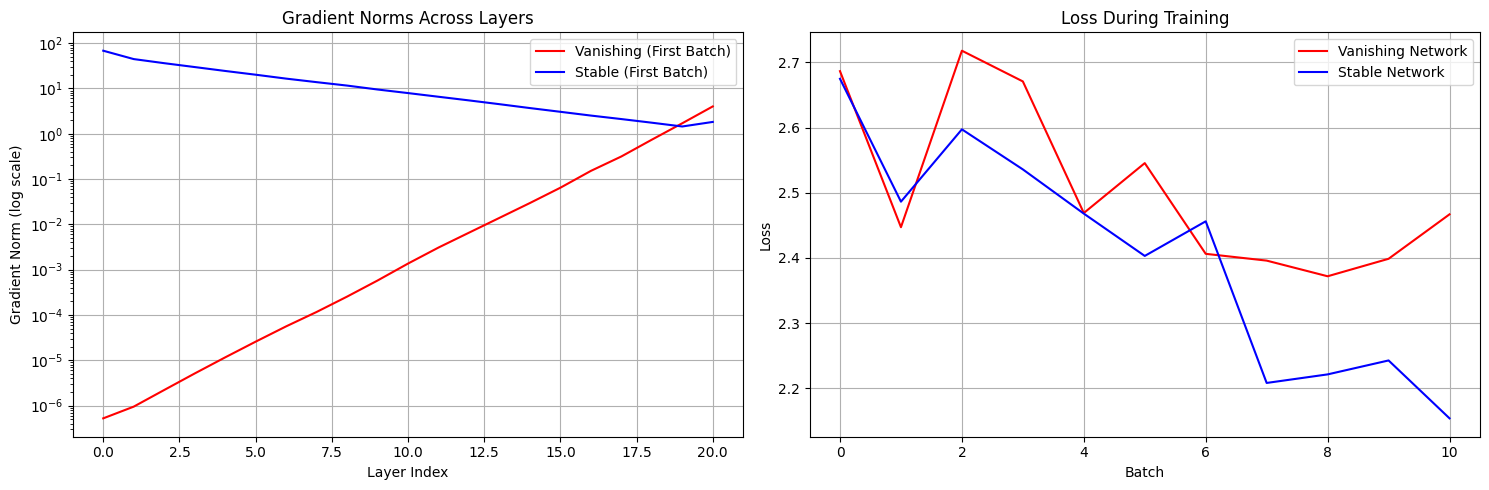


Gradient Statistics (First Batch):
Vanishing Network - Min grad: 5.21e-07, Max grad: 4.01e+00
Stable Network - Min grad: 1.45e+00, Max grad: 6.80e+01


In [3]:


class VanishingNet(nn.Module):
    def __init__(self):
        super(VanishingNet, self).__init__()
        # Very deep network with sigmoid activations
        layers = []
        input_size = 784
        
        # Creating 20 layers to demonstrate the problem clearly
        for _ in range(20):
            layers.append(nn.Linear(input_size, 512))
            layers.append(nn.Sigmoid())  # Sigmoid activation prone to vanishing gradients
            input_size = 512
            
        layers.append(nn.Linear(512, 10))
        self.layers = nn.Sequential(*layers)
        
        # Small weight initialization to worsen vanishing gradients
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0, std=0.1)
                nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        x = x.view(-1, 784)
        return self.layers(x)

class StableNet(nn.Module):
    def __init__(self):
        super(StableNet, self).__init__()
        layers = []
        input_size = 784
        
        # Same depth but with ReLU and batch normalization
        for _ in range(20):
            layers.append(nn.Linear(input_size, 512))
            layers.append(nn.BatchNorm1d(512))  # Add batch normalization
            layers.append(nn.ReLU())  # ReLU instead of Sigmoid
            input_size = 512
            
        layers.append(nn.Linear(512, 10))
        self.layers = nn.Sequential(*layers)
        
        # He initialization for ReLU
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight)
                nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        x = x.view(-1, 784)
        return self.layers(x)

def analyze_gradients(model, criterion, data, target):
    """Analyze gradients at different depths of the network"""
    model.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    
    gradient_norms = []
    for layer in model.layers:
        if isinstance(layer, nn.Linear):
            if layer.weight.grad is not None:
                grad_norm = layer.weight.grad.norm().item()
                gradient_norms.append(grad_norm)
    
    return gradient_norms, loss.item()

def train_and_monitor(model, name):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    all_gradient_norms = []
    losses = []
    
    # Monitor first few batches
    for batch_idx, (data, target) in enumerate(train_loader):
        gradient_norms, loss = analyze_gradients(model, criterion, data, target)
        all_gradient_norms.append(gradient_norms)
        losses.append(loss)
        
        optimizer.step()
        
        if batch_idx >= 10:  # Monitor first 10 batches
            break
    
    return all_gradient_norms, losses

# Train both networks
vanishing_net = VanishingNet()
stable_net = StableNet()

vanishing_grads, vanishing_losses = train_and_monitor(vanishing_net, "Vanishing")
stable_grads, stable_losses = train_and_monitor(stable_net, "Stable")

# Plotting
plt.figure(figsize=(15, 5))

# Plot gradient norms across layers
plt.subplot(1, 2, 1)
plt.semilogy(vanishing_grads[0], 'r-', label='Vanishing (First Batch)')
plt.semilogy(stable_grads[0], 'b-', label='Stable (First Batch)')
plt.title('Gradient Norms Across Layers')
plt.xlabel('Layer Index')
plt.ylabel('Gradient Norm (log scale)')
plt.legend()
plt.grid(True)

# Plot losses
plt.subplot(1, 2, 2)
plt.plot(vanishing_losses, 'r-', label='Vanishing Network')
plt.plot(stable_losses, 'b-', label='Stable Network')
plt.title('Loss During Training')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print gradient statistics
print("\nGradient Statistics (First Batch):")
print(f"Vanishing Network - Min grad: {min(vanishing_grads[0]):.2e}, Max grad: {max(vanishing_grads[0]):.2e}")
print(f"Stable Network - Min grad: {min(stable_grads[0]):.2e}, Max grad: {max(stable_grads[0]):.2e}")